In [2]:
import os, shutil, pathlib

In [3]:
original_dir = pathlib.Path("train")

In [4]:
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [5]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [6]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [10]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

In [13]:
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras",
                                   save_best_only=True,
                                   monitor="val_loss")
]

In [16]:
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 388ms/step - loss: 0.7328 - accuracy: 0.5190 - val_loss: 0.6896 - val_accuracy: 0.5040
Epoch 2/30
63/63 [==============================] - 25s 392ms/step - loss: 0.7099 - accuracy: 0.5510 - val_loss: 0.6686 - val_accuracy: 0.5830
Epoch 3/30
63/63 [==============================] - 25s 396ms/step - loss: 0.6595 - accuracy: 0.6255 - val_loss: 0.8788 - val_accuracy: 0.5490
Epoch 4/30
63/63 [==============================] - 25s 403ms/step - loss: 0.6108 - accuracy: 0.6900 - val_loss: 0.5989 - val_accuracy: 0.6810
Epoch 5/30
63/63 [==============================] - 25s 404ms/step - loss: 0.5615 - accuracy: 0.7125 - val_loss: 0.6343 - val_accuracy: 0.6580
Epoch 6/30
63/63 [==============================] - 26s 409ms/step - loss: 0.5149 - accuracy: 0.7440 - val_loss: 0.8532 - val_accuracy: 0.6030
Epoch 7/30
63/63 [==============================] - 26s 406ms/step - loss: 0.4630 - accuracy: 0.7775 - val_loss: 0.6862 - val_accuracy: 0.6750

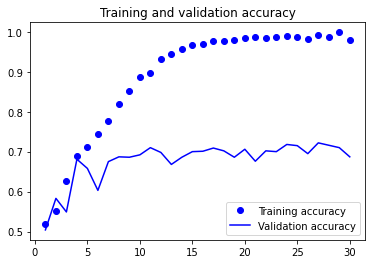

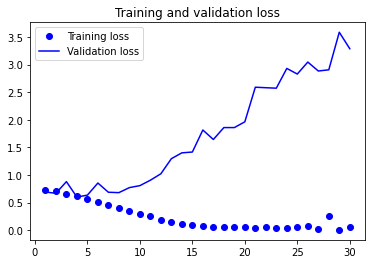

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 80ms/step - loss: 0.5953 - accuracy: 0.6965
Test accuracy: 0.697


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

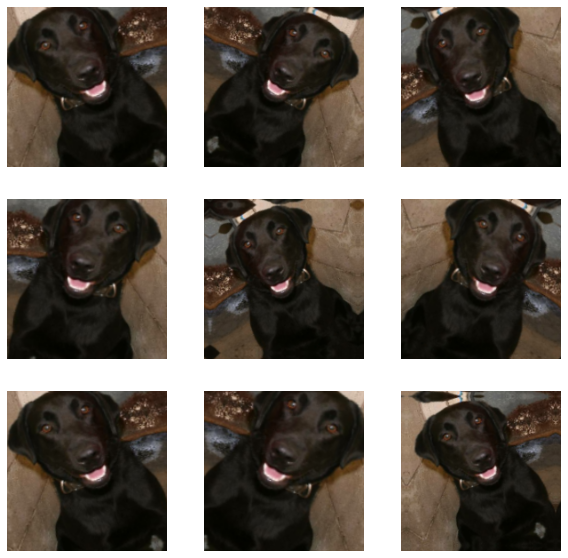

In [21]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [22]:
############
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [24]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 27s 404ms/step - loss: 0.7776 - accuracy: 0.5120 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 27s 421ms/step - loss: 0.6964 - accuracy: 0.5205 - val_loss: 0.6867 - val_accuracy: 0.5890
Epoch 3/100
63/63 [==============================] - 27s 422ms/step - loss: 0.6944 - accuracy: 0.5575 - val_loss: 0.6821 - val_accuracy: 0.5290
Epoch 4/100
63/63 [==============================] - 27s 426ms/step - loss: 0.6938 - accuracy: 0.5715 - val_loss: 0.6777 - val_accuracy: 0.5500
Epoch 5/100
63/63 [==============================] - 27s 420ms/step - loss: 0.6756 - accuracy: 0.5970 - val_loss: 0.6485 - val_accuracy: 0.6150
Epoch 6/100
63/63 [==============================] - 27s 425ms/step - loss: 0.6659 - accuracy: 0.6295 - val_loss: 0.6435 - val_accuracy: 0.6320
Epoch 7/100
63/63 [==============================] - 27s 425ms/step - loss: 0.6387 - accuracy: 0.6345 - val_loss: 0.6655 - val_accuracy:

63/63 [==============================] - 27s 425ms/step - loss: 0.2607 - accuracy: 0.8925 - val_loss: 0.4996 - val_accuracy: 0.8220
Epoch 58/100
63/63 [==============================] - 26s 419ms/step - loss: 0.2521 - accuracy: 0.8945 - val_loss: 0.5361 - val_accuracy: 0.8230
Epoch 59/100
63/63 [==============================] - 28s 437ms/step - loss: 0.2483 - accuracy: 0.9005 - val_loss: 0.5362 - val_accuracy: 0.8360
Epoch 60/100
63/63 [==============================] - 27s 428ms/step - loss: 0.2536 - accuracy: 0.8985 - val_loss: 0.4923 - val_accuracy: 0.8270
Epoch 61/100
63/63 [==============================] - 27s 427ms/step - loss: 0.2475 - accuracy: 0.9010 - val_loss: 0.7476 - val_accuracy: 0.7620
Epoch 62/100
63/63 [==============================] - 27s 430ms/step - loss: 0.2281 - accuracy: 0.9095 - val_loss: 0.6388 - val_accuracy: 0.8110
Epoch 63/100
63/63 [==============================] - 27s 432ms/step - loss: 0.2498 - accuracy: 0.8985 - val_loss: 0.5360 - val_accuracy: 0.835

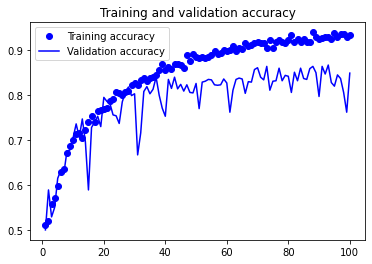

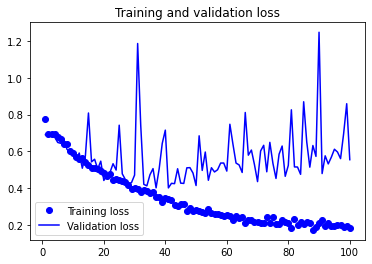

In [25]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 83ms/step - loss: 0.4497 - accuracy: 0.8180
Test accuracy: 0.818


In [28]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(180,180,3))

58900480/58889256 [==============================] - 5s 0us/step


In [29]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [34]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [37]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_features, train_labels, epochs=20, validation_data=(val_features, val_labels),callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 17.6450 - accuracy: 0.9230 - val_loss: 12.0683 - val_accuracy: 0.9270
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 4.2601 - accuracy: 0.9725 - val_loss: 4.8643 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 2.2936 - accuracy: 0.9880 - val_loss: 5.5761 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 2.1586 - accuracy: 0.9865 - val_loss: 4.2992 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 0.8313 - accuracy: 0.9940 - val_loss: 6.7380 - val_accuracy: 0.9650
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 0.6264 - accuracy: 0.9930 - val_loss: 3.9447 - val_accuracy: 0.9800
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.5401 - accuracy: 0.9940 - val_loss: 8.8892 - val_accuracy: 0.9570
Epoch 8/20


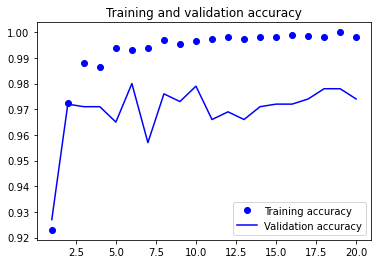

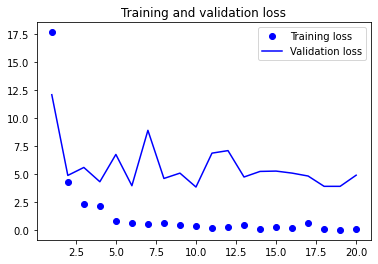

In [38]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
###################
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
conv_base.trainable = False

In [40]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [41]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

In [43]:
callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [45]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - 190s 3s/step - loss: 7.7320 - accuracy: 0.9385 - val_loss: 3.8853 - val_accuracy: 0.9680
Epoch 2/50
63/63 [==============================] - 171s 3s/step - loss: 7.5420 - accuracy: 0.9455 - val_loss: 3.2827 - val_accuracy: 0.9780
Epoch 3/50
63/63 [==============================] - 172s 3s/step - loss: 4.4628 - accuracy: 0.9610 - val_loss: 5.1937 - val_accuracy: 0.9660
Epoch 4/50
63/63 [==============================] - 168s 3s/step - loss: 4.2802 - accuracy: 0.9650 - val_loss: 24.3685 - val_accuracy: 0.9130
Epoch 5/50
63/63 [==============================] - 179s 3s/step - loss: 3.7515 - accuracy: 0.9715 - val_loss: 7.0701 - val_accuracy: 0.9620
Epoch 6/50
63/63 [==============================] - 171s 3s/step - loss: 3.9088 - accuracy: 0.9655 - val_loss: 3.8104 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 167s 3s/step - loss: 2.7689 - accuracy: 0.9740 - val_loss: 5.3519 - val_accuracy: 0.9730
Epoch 8/50
6

In [46]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [47]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [48]:
model.compile(loss="binary_crossentropy",
             optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [49]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 221s 4s/step - loss: 0.4370 - accuracy: 0.9895 - val_loss: 2.0472 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 283s 5s/step - loss: 0.1756 - accuracy: 0.9935 - val_loss: 2.5137 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 285s 5s/step - loss: 0.2184 - accuracy: 0.9920 - val_loss: 1.7467 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 287s 5s/step - loss: 0.2000 - accuracy: 0.9905 - val_loss: 1.9841 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 287s 5s/step - loss: 0.3596 - accuracy: 0.9920 - val_loss: 2.1047 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 283s 5s/step - loss: 0.3398 - accuracy: 0.9930 - val_loss: 2.0760 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 289s 5s/step - loss: 0.2388 - accuracy: 0.9915 - val_loss: 2.4235 - val_accuracy: 0.9770
Epoch 8/30
63

In [50]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 152s 2s/step - loss: 1.8681 - accuracy: 0.9755
Test accuracy: 0.975
